# ANN Assignment - Digits

unistalling the current version of the tensorflow because it is returning an error for ***keras.wrappers*** library. ***tensorflow 2.12.0*** executes with the same library successfully hence installing this version of tensorflow.




In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.12.0
  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.12.0 which is incompatible.


In [1]:
#load basic library
import numpy as np
from sklearn.datasets import load_digits

# load the digits dataset
digits = load_digits()
# digits
# digits['data']
# digits['target']
# digits['images']
# digits.data
# digits.target

In [2]:
# splitting the dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=42)

In [3]:
X_train.shape

(1347, 64)

In [4]:
X_train

array([[ 0.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  5., 16., ...,  6.,  1.,  0.],
       [ 0.,  0.,  4., ...,  2.,  0.,  0.],
       ...,
       [ 0.,  0.,  9., ..., 16.,  2.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]])

---

* The fit_transform method combines two steps: fitting the scaler to the data and transforming the data.
* When you call fit_transform on a dataset, the scaler learns the parameters (mean and standard deviation) from the data and then transforms the data based on those parameters.
* The transform method applies a transformation to the data based on the parameters learned during the fitting step.
* When you call transform on a dataset, it applies the transformation using the parameters learned during the fit step.

By using fit_transform on the training dataset and transform on the test dataset, we ensure that the scaling is consistent across both datasets and that the model is evaluated on data that has been transformed in the same way as the training data. This helps prevent bias and ensures fair evaluation of the model's performance on unseen data.

In [5]:
# implementing standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.        , -0.34658389, -0.67111503, ..., -1.15783495,
        -0.50770266, -0.19895848],
       [ 0.        ,  5.19793507,  2.23828434, ..., -0.13881915,
        -0.26774635, -0.19895848],
       [ 0.        , -0.34658389, -0.25548655, ..., -0.81816302,
        -0.50770266, -0.19895848],
       ...,
       [ 0.        , -0.34658389,  0.78358465, ...,  1.55954051,
        -0.02779004, -0.19895848],
       [ 0.        , -0.34658389, -0.87892927, ..., -1.15783495,
        -0.50770266, -0.19895848],
       [ 0.        , -0.34658389, -0.87892927, ..., -0.98799898,
        -0.50770266, -0.19895848]])

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_model(hidden_layer_sizes, activation='relu', alpha=0.0001):
  model = Sequential() # create a Sequential model
  model.add( Dense( hidden_layer_sizes[0], activation=activation, input_shape=( X_train.shape[1],) ) ) # first hidden layer

  for units in hidden_layer_sizes[1:]:
    model.add(Dense(units, activation=activation)) # additional hidden layers

  model.add(Dense(10, activation='softmax')) # last hidden layer

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # model compilation
  return model

In [8]:
# !pip install scikeras

# from scikeras.wrappers import KerasClassifier

scikit-learn's API expects estimators to implement certain methods (fit, predict, etc.), which are not directly provided by Keras models. The ***KerasClassifier*** wraps the Keras model and implements these methods to make it compatible with scikit-learn's API, allowing seamless integration with scikit-learn's utilities.

In [7]:
# using KerasClassifier wrapper to use with GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

<ipython-input-7-dfca114c76ee>:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [8]:
# setup hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)], # neurons in each layer
    'activation': ['relu'], # different activation functions
    # 'activation': ['relu', 'tanh', 'sigmoid'], # different activation functions
    # 'alpha': [0.0001, 0.001, 0.01], #
    'epochs': [10, 20, 15],  # number of epochs
    'batch_size': [16, 32, 64]  # batch size
}

***GridSearchCV*** doesn't directly store the training history for each model it evaluates during the hyperparameter search. It only keeps track of the best model's information.

That is why we can create a custom callback function that collects the training metrics during each epoch.

---



**1. Custom Callback Class (`HistoryTracker`):**

This class inherits from `keras.callbacks.Callback`. Callbacks are essentially functions you can register with the Keras model to be invoked at specific points during the training process.

`__init__(self)`: This is the constructor of the class. It gets called whenever you create an instance of `HistoryTracker`. Here, it initializes an empty list named `self.histories` to store the training histories captured later.

`on_train_end(self, logs=None)`: This method is one of the callback methods inherited from `keras.callbacks.Callback`. It gets called at the end of each training epoch (iteration).

* Inside this method, it retrieves the current model's training history using `self.model.history.history`. This attribute holds a dictionary containing the training metrics (like accuracy, loss) for each epoch.
* The retrieved history is then appended to the `self.histories` list using the `append` method.

**2. Creating and Using the Callback:**

`history_tracker = HistoryTracker()`: This line creates an instance of the `HistoryTracker`` class, essentially creating a new callback object.

`grid_search.fit(..., callbacks=[history_tracker])`: Here, you pass the `history_tracker` instance as part of the `callbacks` argument to the `grid_search.fit method`. This tells **GridSearchCV** to use this callback during the model fitting process for each hyperparameter configuration.

**3. Accessing Captured Histories:**

`all_history = history_tracker.histories`: After the GridSearchCV finishes evaluating all models, you can access the captured training histories. This line retrieves the list of histories stored in the callback object's `histories` attribute and assigns it to the variable `all_history`.

--
Now, `all_history` will be a list where each element represents the training history (containing metrics like accuracy and loss) for a specific model evaluated during the GridSearchCV process. You can then iterate through this list and extract the desired metrics (accuracy, validation accuracy) to plot them.

---

In [9]:
from tensorflow.keras.callbacks import Callback

class HistoryTracker(Callback):
  def __init__(self):
    self.histories = []

  def on_train_end(self, logs=None):
    self.histories.append(self.model.history.history)

# Create the callback instance
history_tracker = HistoryTracker()

In [10]:
from sklearn.model_selection import GridSearchCV

# perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, scoring='accuracy')
# grid_search.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test))
grid_search.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), callbacks=[history_tracker])

Fitting 3 folds for each of 27 candidates, totalling 81 fits
15/15 [==============================] - 0s 2ms/step
[CV] END activation=relu, batch_size=16, epochs=10, hidden_layer_sizes=(100,); total time=   6.9s
15/15 [==============================] - 0s 3ms/step
[CV] END activation=relu, batch_size=16, epochs=10, hidden_layer_sizes=(100,); total time=   5.4s
15/15 [==============================] - 0s 3ms/step
[CV] END activation=relu, batch_size=16, epochs=10, hidden_layer_sizes=(100,); total time=   4.7s
15/15 [==============================] - 0s 2ms/step
[CV] END activation=relu, batch_size=16, epochs=10, hidden_layer_sizes=(50, 50); total time=   3.6s
15/15 [==============================] - 0s 1ms/step
[CV] END activation=relu, batch_size=16, epochs=10, hidden_layer_sizes=(50, 50); total time=   2.8s
15/15 [==============================] - 0s 2ms/step
[CV] END activation=relu, batch_size=16, epochs=10, hidden_layer_sizes=(50, 50); total time=   2.6s
15/15 [====================

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x795724675b40>,
             param_grid={'activation': ['relu'], 'batch_size': [16, 32, 64],
                         'epochs': [10, 20, 15],
                         'hidden_layer_sizes': [(100,), (50, 50),
                                                (50, 100, 50)]},
             scoring='accuracy', verbose=2)

In [11]:
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'activation': 'relu', 'batch_size': 16, 'epochs': 15, 'hidden_layer_sizes': (100,)}


In [12]:
from sklearn.metrics import accuracy_score

best_model = grid_search.best_estimator_

# evaluate the best model on the traning set
y_pred_train = best_model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", accuracy_train)

# evaluate the best model on the testing set
y_pred_test = best_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", accuracy_test)


43/43 [==============================] - 0s 1ms/step
Training Accuracy: 1.0
15/15 [==============================] - 0s 2ms/step
Testing Accuracy: 0.9755555555555555


In [13]:
from sklearn.metrics import classification_report

print("Classification report:")
print(classification_report(y_test, y_pred_test))

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.97      1.00      0.99        37
           2       1.00      1.00      1.00        38
           3       1.00      0.93      0.97        46
           4       1.00      1.00      1.00        55
           5       0.95      0.95      0.95        59
           6       0.98      0.98      0.98        45
           7       0.98      0.98      0.98        41
           8       0.95      0.95      0.95        38
           9       0.94      0.98      0.96        48

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [14]:
print(grid_search.best_estimator_.model.history.history)

{}


In [15]:
# Access histories from the callback
all_history = history_tracker.histories
# all_history[81]['val_accuracy']

In [16]:
print(len(all_history))

82


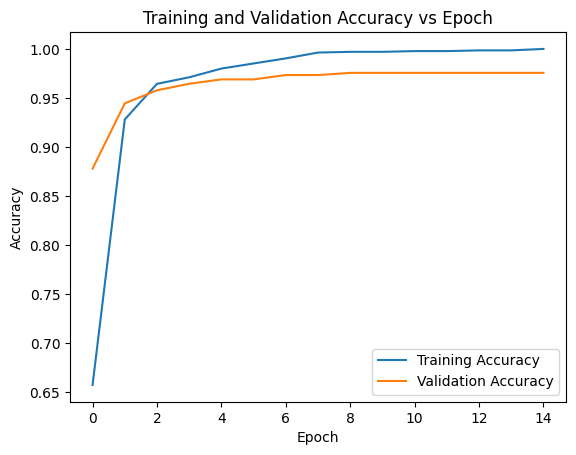

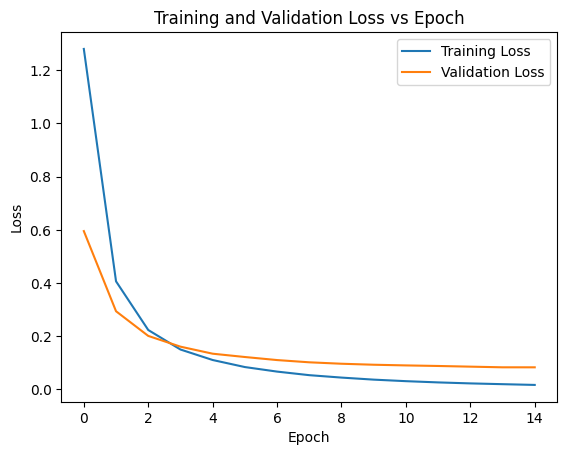

In [17]:
import matplotlib.pyplot as plt

# Plot training accuracy vs epoch
plt.plot(all_history[81]['accuracy'], label='Training Accuracy')
plt.plot(all_history[81]['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()
plt.show()

# Plot training loss vs epoch
plt.plot(all_history[81]['loss'], label='Training Loss')
plt.plot(all_history[81]['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()
plt.show()